In [1]:
import math

import numpy as np
import torch
import torchvision.utils
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity

In [2]:
def imsshow(imgs, titles=None, num_col=5, dpi=100, cmap=None, is_colorbar=False, is_ticks=False):
    '''
    assume imgs's shape is (Nslice, Nx, Ny)
    '''
    num_imgs = len(imgs)
    num_row = math.ceil(num_imgs / num_col)
    fig_width = num_col * 3
    if is_colorbar:
        fig_width += num_col * 1.5
    fig_height = num_row * 3
    fig = plt.figure(dpi=dpi, figsize=(fig_width, fig_height))
    for i in range(num_imgs):
        ax = plt.subplot(num_row, num_col, i + 1)
        im = ax.imshow(imgs[i], cmap=cmap)
        if titles:
            plt.title(titles[i])
        if is_colorbar:
            cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.01, ax.get_position().height])
            plt.colorbar(im, cax=cax)
        if not is_ticks:
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()
    plt.close('all')

## 读取数据集

In [3]:
dataset = np.load('../cine.npz')['dataset']
print(f"The shape of dataset is {dataset.shape}.")
print(f"The type of dataset is {dataset.dtype}.")

The shape of dataset is (200, 20, 192, 192).
The type of dataset is float32.


## 随机生成mask

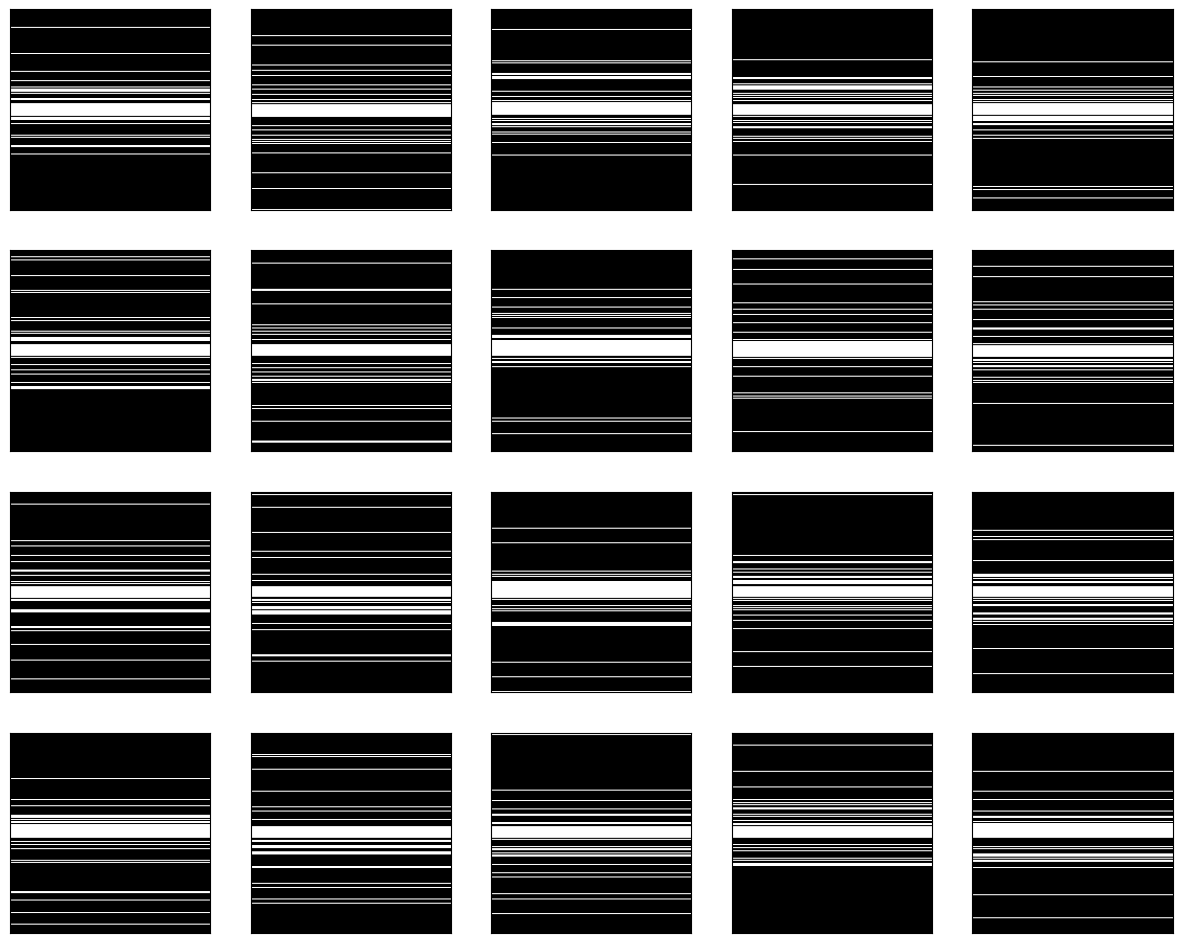

In [4]:
from CS_mask import cartesian_mask
seed=1012
np.random.seed(seed)
mask = cartesian_mask(shape=(1, 20, 192, 192), acc=6, sample_n=10, centred=True)
imsshow(mask[0, :, :, :], num_col=5, cmap='gray')

## 定义傅里叶变换和逆变换

In [5]:
#傅里叶变换
def fft2c(img):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))
#傅里叶逆变换
def ifft2c(img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(img)))

## 对dataset里面的数据傅里叶变换得到k-space数据

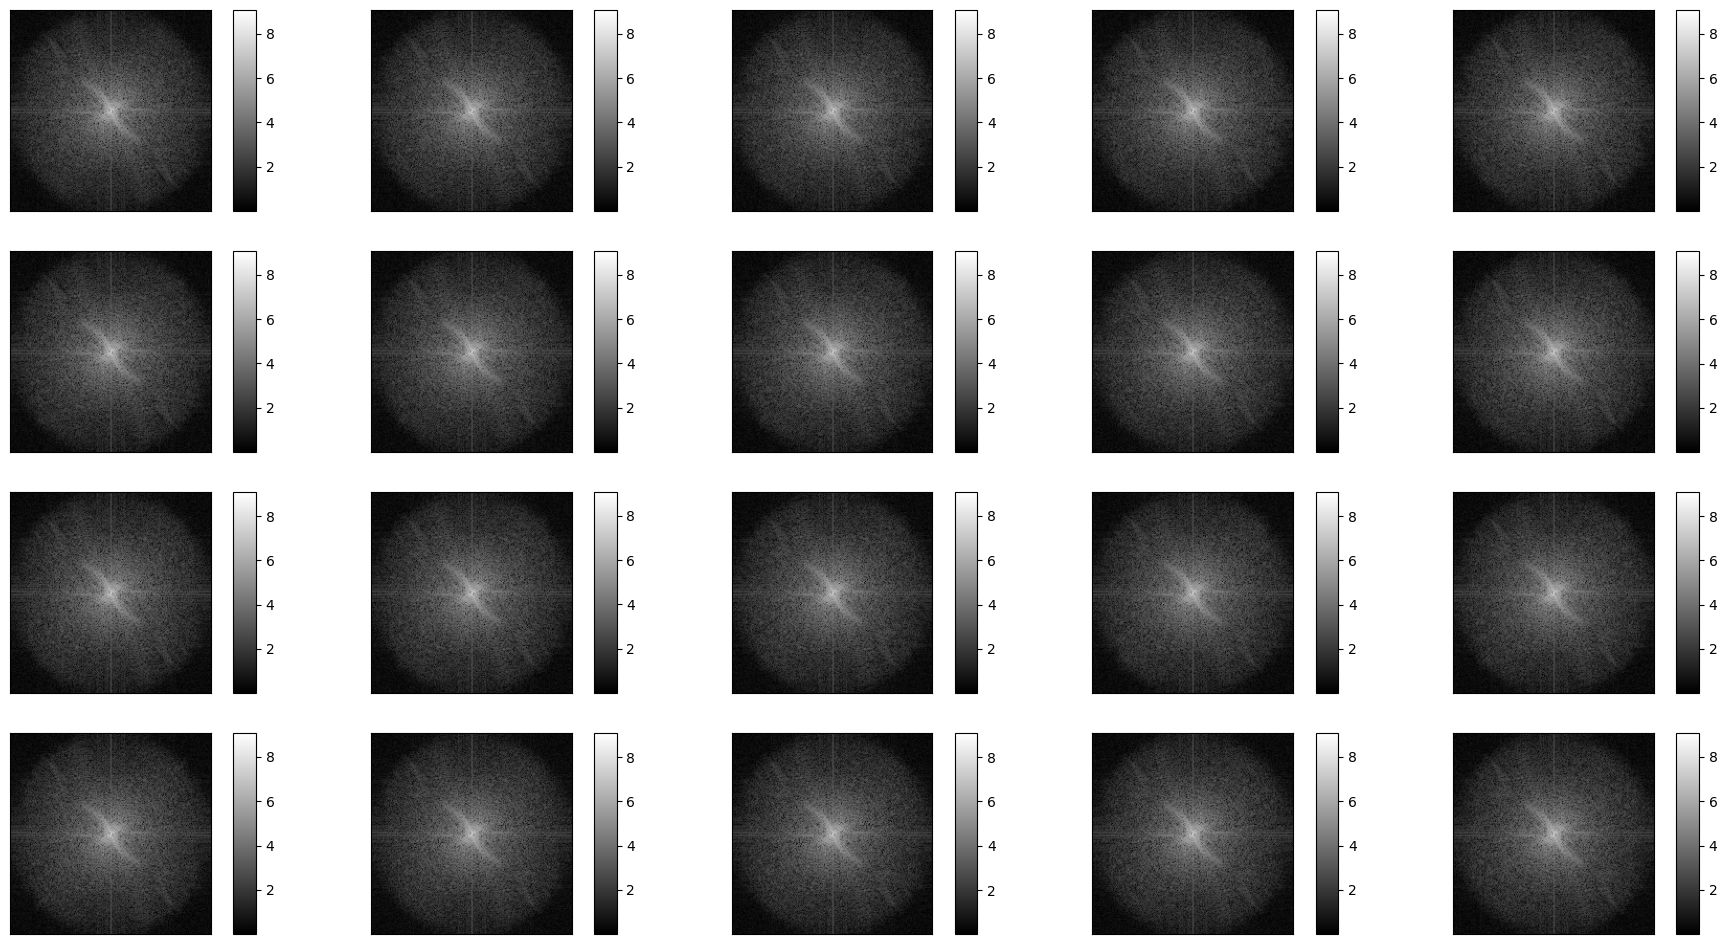

In [6]:
img_fft = fft2c(dataset)
img_fft_abs = np.abs(img_fft)
img_fft_abs_log = np.log(img_fft_abs + 1)
imsshow(img_fft_abs_log[100], num_col=5, cmap='gray', is_colorbar=True)

## 添加mask，然后逆变换

In [7]:
img_masked = img_fft * mask
img_recon = ifft2c(img_masked)
img_recon_abs = np.abs(img_recon)

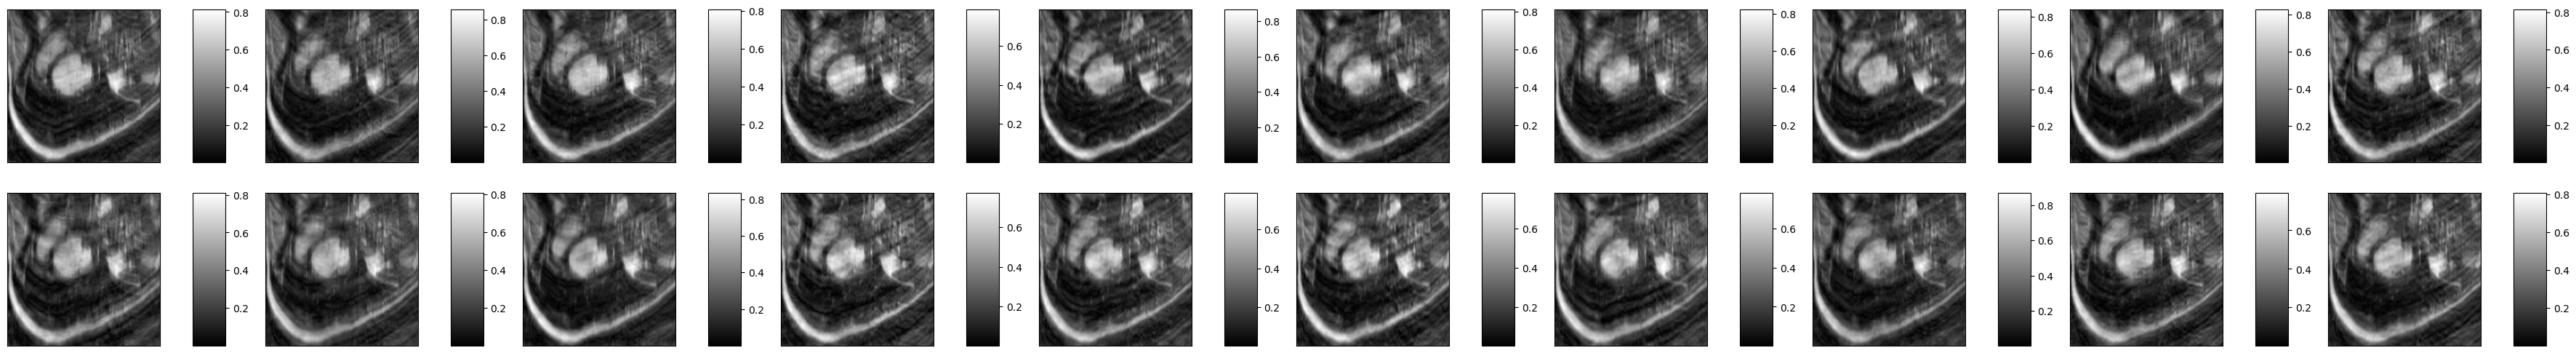

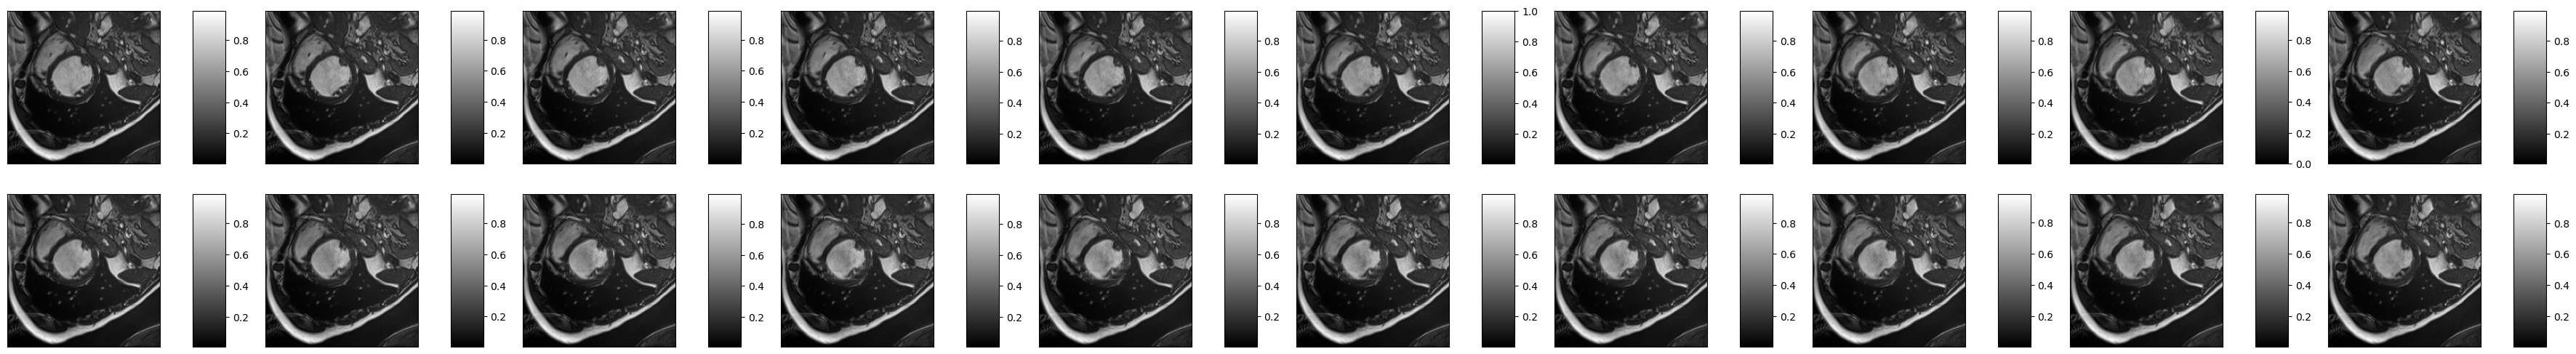

In [8]:
imsshow(img_recon_abs[100], num_col=10, cmap='gray', is_colorbar=True)
imsshow(dataset[100], num_col=10, cmap='gray', is_colorbar=True)

## 取一帧的mask

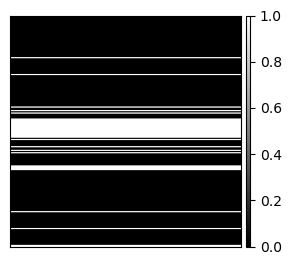

In [9]:
imsshow([mask[0, 12, :, :]], num_col=1, cmap='gray', is_colorbar=True)

## 画ky-t图

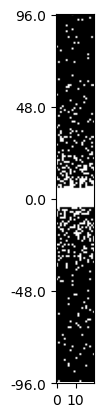

In [10]:
kyt=np.ones((192,20))
for i in range(20):
    zeros=np.where(mask[0,i,:,:]==0)
    kyt[zeros[0],i]=0
plt.imshow(kyt,cmap='gray')
plt.yticks(np.linspace(0,192,5),np.linspace(96,-96,5))
plt.show()

## 保存mask和伪影数据

In [11]:
np.savez('../data_after_prob1.npz',mask=mask,aliased_image=img_recon_abs)